In [ ]:
import collections
import json
import os
import shutil
import time
import math
import subprocess

import librosa
import matplotlib.pyplot as plt
import numpy as np
import soundfile as sf
import torch
from diffusers import LMSDiscreteScheduler, StableDiffusionPipeline
from IPython import display as IPdisplay
from PIL import Image
from tqdm.auto import tqdm
from transformers import logging

from chords.infer import predict_chords
from flamingo.inference.inference import caption_from_file

# load audio
audio = "sample.mp3"
# granularity of image generation
fps = 8

y, sr = librosa.load(audio, sr=16000)

### Caption

In [2]:
# delete dir if it already exists
if os.path.exists("./flamingo/files_to_process"):
    shutil.rmtree("./flamingo/files_to_process")

# split into 10 second chunks
chunk_length = 10 * sr
num_chunks = len(y) // chunk_length
y_chunks = []
for i in range(num_chunks):
    start = i * chunk_length
    end = (i + 1) * chunk_length
    y_chunks.append(y[start:end])
for i, chunk in enumerate(y_chunks):
    if not os.path.exists("./flamingo/files_to_process"):
        os.makedirs("./flamingo/files_to_process")
    sf.write(f"./flamingo/files_to_process/chunk_{i}.wav", chunk, sr)

# create jsonl file for captioning with audio flamingo
caption_prompt = (
    "Describe this audio in 10 words or less. Focus on its vibe/mood as a music piece"
)
lines = []
for i in range(num_chunks):
    lines.append(
        {
            "path": f"./flamingo/files_to_process/chunk_{i}.wav",
            "prompt": caption_prompt,
        }
    )
# write to jsonl file in ./flamingo/files_to_process/inference.jsonl
with open("./flamingo/files_to_process/inference.jsonl", "w", encoding="utf-8") as f:
    for line in lines:
        f.write(json.dumps(line) + "\n")
# caption
captions = caption_from_file("./flamingo/files_to_process/inference.jsonl")

# Process each caption
for i in range(len(captions)):
    if captions[i] in ["no response", "no caption", ""]:
        # First try previous caption
        if i > 0 and captions[i - 1] not in ["no response", "no caption", ""]:
            captions[i] = captions[i - 1]
        # Then try next caption
        elif i < len(captions) - 1 and captions[i + 1] not in [
            "no response",
            "no caption",
            "",
        ]:
            captions[i] = captions[i + 1]
        # Use default if no valid neighbors
        else:
            captions[i] = "Ambiguous audio."

# delete folder
shutil.rmtree("./flamingo/files_to_process")

# create equally spaces timestamps for each chunk
events_captions = []
for i in range(num_chunks):
    start = i * (len(y) / sr) / num_chunks
    events_captions.append(
        (
            start,
            "An abstract, gradient-based visualization for this music piece: "
            + captions[i],
        )
    )
print(events_captions)

Fetching 12 files: 100%|██████████| 12/12 [00:00<00:00, 11958.10it/s]


loaded NVCLAP model: ./flamingo/clap_ckpt/epoch_15.pt


Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.


Flamingo model initialized with 438,012,336 trainable parameters (audio transformer has 75,538,432, LM has 362,473,904)


Captioning audio chunks: 100%|██████████| 1/1 [00:02<00:00,  2.30s/it]


[(0.0, "An abstract, gradient-based visualization for this music piece: this song is a slow and soothing electronic music track, with a synth-heavy sound that is full of intricate textures and layers. the synth's ability to create a wide range of sounds makes it an ideal choice for a dreamy and ethereal soundscape")]


### Major shifts

mfcc_increase: 3 changes
  Timestamps: [1.4080000000000001, 10.624, 13.824]
mfcc_decrease: 2 changes
  Timestamps: [12.288000000000002, 14.848]
rms_increase: 1 changes
  Timestamps: [10.879999999999999]
rms_decrease: 0 changes


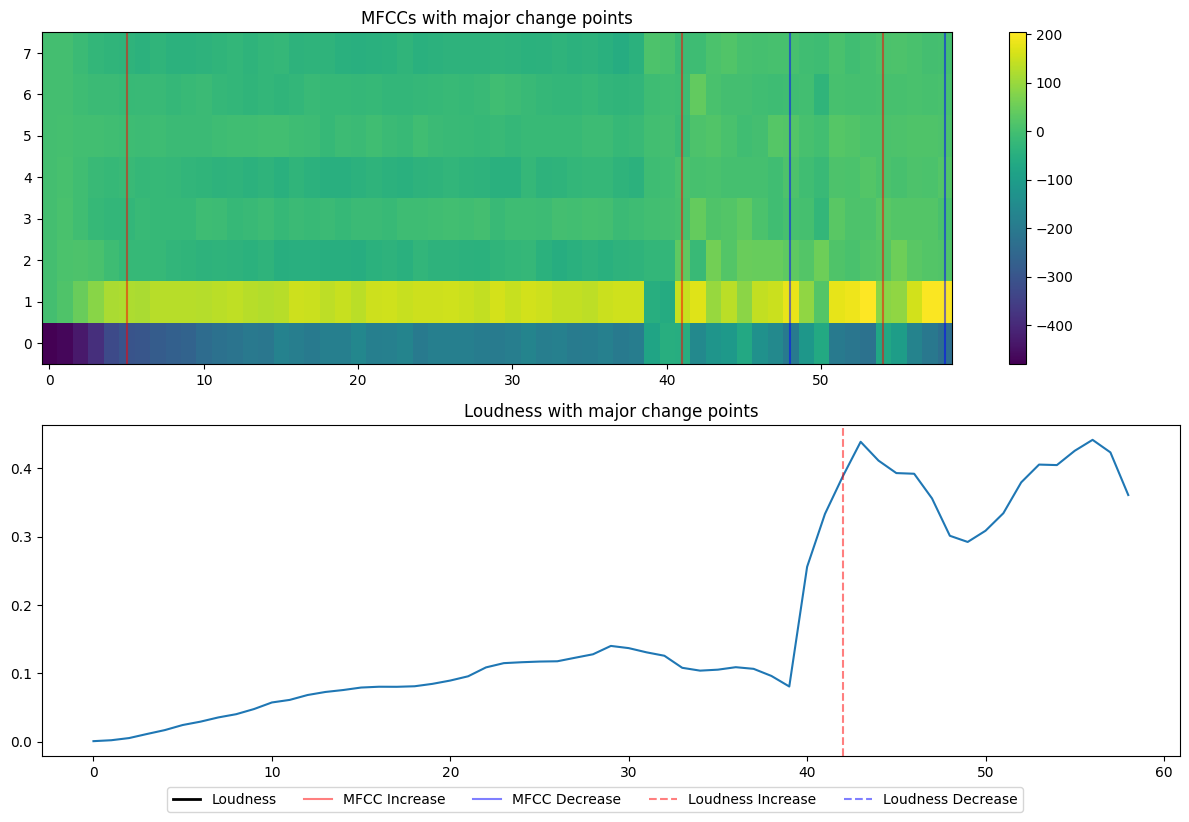

[(1.4080000000000001, 'Complex visualization.'), (10.624, 'Complex visualization.'), (13.824, 'Complex visualization.'), (12.288000000000002, 'Simple visualization.'), (14.848, 'Simple visualization.')]
[(10.879999999999999, 'Intense visualization.')]


In [3]:
# get sequences of features over time
hop_length = 512 * 8  # Use consistent hop length
mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=8, hop_length=hop_length)
loudness = librosa.feature.rms(y=y, frame_length=2048 * 8, hop_length=hop_length)


# get major turn points in these features
def detect_significant_changes(mfccs, loudness, window_size=4):
    """
    Detects significant changes in MFCCs and loudness over time using a sliding window.
    Returns a dictionary with lists of timestamps for each change type.
    """
    # Dictionary to store timestamps by category - only major changes
    changes = {
        "mfcc_increase": [],
        "mfcc_decrease": [],
        "rms_increase": [],
        "rms_decrease": [],
    }

    # Define thresholds - only major thresholds
    major_mfcc_threshold = 25
    major_loudness_threshold = 0.15

    # Number of frames to analyze (minimum of both feature arrays)
    n_frames = min(mfccs.shape[1], loudness.shape[1])

    # Use a sliding window to detect changes
    for i in range(window_size, n_frames):
        # Calculate change in MFCCs
        mfcc_diff = np.mean(np.abs(mfccs[:, i] - mfccs[:, i - window_size]))
        mfcc_direction = np.mean(mfccs[:, i]) > np.mean(mfccs[:, i - window_size])

        # Track MFCC changes - only major changes
        if mfcc_diff > major_mfcc_threshold:
            timestamp = frame_to_time(i, sr, hop_length=hop_length)
            if mfcc_direction:
                changes["mfcc_increase"].append(timestamp)
            else:
                changes["mfcc_decrease"].append(timestamp)

        # Calculate change in loudness
        loudness_diff = np.abs(loudness[0, i] - loudness[0, i - window_size])
        loudness_direction = loudness[0, i] > loudness[0, i - window_size]

        # Track loudness (RMS) changes - only major changes
        if loudness_diff > major_loudness_threshold:
            timestamp = frame_to_time(i, sr, hop_length=hop_length)
            if loudness_direction:
                changes["rms_increase"].append(timestamp)
            else:
                changes["rms_decrease"].append(timestamp)

    # Consolidate nearby change points
    consolidated_changes = {}
    for category in changes.keys():
        consolidated_changes[category] = consolidate_timestamps(
            changes[category], time_threshold=1.0
        )

    # Also store the frame numbers for plotting purposes
    consolidated_changes["frames"] = {
        "mfcc_increase": [],
        "mfcc_decrease": [],
        "rms_increase": [],
        "rms_decrease": [],
    }

    # Convert timestamps back to frame numbers
    for category in consolidated_changes.keys():
        if category != "frames":
            consolidated_changes["frames"][category] = [
                time_to_frame(t, sr, hop_length=hop_length)
                for t in consolidated_changes[category]
            ]

    return consolidated_changes


def consolidate_timestamps(timestamps, time_threshold=1.0):
    """
    Group timestamps that are within time_threshold seconds of each other
    and return a single timestamp for each group (the average of the group).
    """
    if not timestamps:
        return []

    # Sort timestamps
    sorted_timestamps = sorted(timestamps)

    # Initialize result with the first timestamp
    consolidated = []
    current_group = [sorted_timestamps[0]]

    # Group timestamps that are close to each other
    for t in sorted_timestamps[1:]:
        if t - current_group[-1] <= time_threshold:
            # Add to current group
            current_group.append(t)
        else:
            # Finalize current group and start a new one
            consolidated.append(sum(current_group) / len(current_group))
            current_group = [t]

    # Add the last group
    if current_group:
        consolidated.append(sum(current_group) / len(current_group))

    return consolidated


def frame_to_time(frame_number, sr, hop_length=512 * 8):
    """Convert frame number to time in seconds."""
    return frame_number * hop_length / sr


def time_to_frame(time_sec, sr, hop_length=512 * 8):
    """Convert time in seconds to frame number."""
    return int(time_sec * sr / hop_length)


changes = detect_significant_changes(mfccs, loudness)

# Print the number of detected changes
for category, timestamps in changes.items():
    if category != "frames":
        print(f"{category}: {len(timestamps)} changes")
        if timestamps:
            print(f"  Timestamps: {timestamps}")

# Plot with color-coded change points
plt.figure(figsize=(12, 8))

# Plot MFCCs with change points
plt.subplot(2, 1, 1)
plt.title("MFCCs with major change points")
plt.imshow(mfccs, aspect="auto", origin="lower")
plt.colorbar()

# Add MFCC change markers
for frame in changes["frames"]["mfcc_increase"]:
    plt.axvline(x=frame, color="red", linestyle="-", alpha=0.5)
for frame in changes["frames"]["mfcc_decrease"]:
    plt.axvline(x=frame, color="blue", linestyle="-", alpha=0.5)

# Plot Loudness with change points
plt.subplot(2, 1, 2)
plt.title("Loudness with major change points")
plt.plot(loudness[0])

# Add RMS change markers
for frame in changes["frames"]["rms_increase"]:
    plt.axvline(x=frame, color="red", linestyle="--", alpha=0.5)
for frame in changes["frames"]["rms_decrease"]:
    plt.axvline(x=frame, color="blue", linestyle="--", alpha=0.5)

# Add a legend
custom_lines = [
    plt.Line2D([0], [0], color="black", lw=2),
    plt.Line2D([0], [0], color="red", linestyle="-", alpha=0.5),
    plt.Line2D([0], [0], color="blue", linestyle="-", alpha=0.5),
    plt.Line2D([0], [0], color="red", linestyle="--", alpha=0.5),
    plt.Line2D([0], [0], color="blue", linestyle="--", alpha=0.5),
]

plt.figlegend(
    custom_lines,
    [
        "Loudness",
        "MFCC Increase",
        "MFCC Decrease",
        "Loudness Increase",
        "Loudness Decrease",
    ],
    loc="lower center",
    ncol=5,
    bbox_to_anchor=(0.5, -0.03),
)

plt.tight_layout()
plt.show()

# get timestamp - description for each event
events_mfcc = []
events_rms = []
for i in range(len(changes["mfcc_increase"])):
    events_mfcc.append(
        (
            changes["mfcc_increase"][i],
            "Complex visualization.",
        )
    )
for i in range(len(changes["mfcc_decrease"])):
    events_mfcc.append(
        (
            changes["mfcc_decrease"][i],
            "Simple visualization.",
        )
    )
for i in range(len(changes["rms_increase"])):
    events_rms.append(
        (
            changes["rms_increase"][i],
            "Intense visualization.",
        )
    )
for i in range(len(changes["rms_decrease"])):
    events_rms.append(
        (
            changes["rms_decrease"][i],
            "Calm visualization.",
        )
    )

print(events_mfcc)
print(events_rms)

### Chord recognition

I comp-creativity 04-26 19:36:13.951 infer.py:50] label type: Major and minor
I comp-creativity 04-26 19:36:14.055 infer.py:60] restore model
I comp-creativity 04-26 19:36:14.056 infer.py:66] Processing file: input.mp3
I comp-creativity 04-26 19:36:14.825 infer.py:71] audio file loaded and feature computation success : input.mp3


[(0.0, 'Main color: black'), (10.092592592592592, 'Main color: purple'), (10.648148148148147, 'Main color: black'), (11.018518518518517, 'Main color: yellow'), (15.648148148148147, 'Main color: dark red'), (20.0, 'Main color: brown'), (24.444444444444443, 'Main color: purple'), (28.888888888888886, 'Main color: dark yellow'), (30.0, 'Main color: yellow'), (33.425925925925924, 'Main color: red'), (35.74074074074074, 'Main color: dark red'), (36.75925925925926, 'Main color: red'), (37.77777777777778, 'Main color: brown'), (42.22222222222222, 'Main color: purple'), (46.666666666666664, 'Main color: yellow'), (51.85185185185185, 'Main color: red'), (54.07407407407407, 'Main color: purple'), (55.55555555555555, 'Main color: brown'), (60.0, 'Main color: purple'), (66.66666666666666, 'Main color: dark yellow'), (66.75925925925925, 'Main color: yellow'), (71.48148148148148, 'Main color: red'), (73.79629629629629, 'Main color: purple'), (75.55555555555556, 'Main color: brown'), (80.0, 'Main col

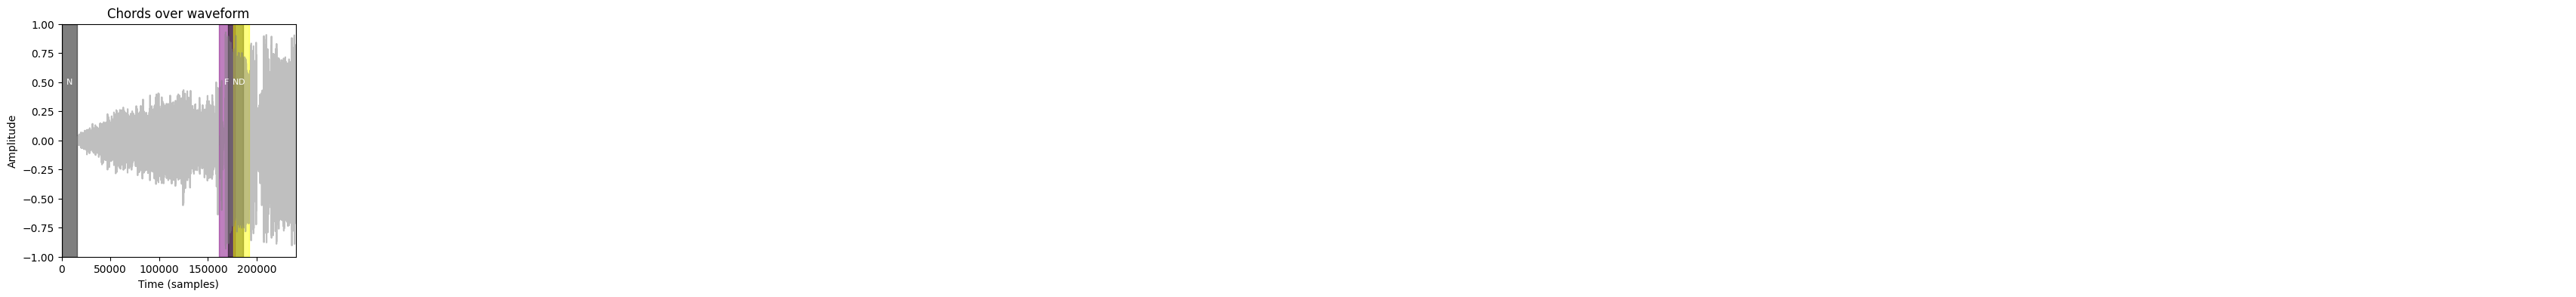

In [16]:
chords = predict_chords("input.mp3")

# map each of the 12 pitch classes to a color
pitch_colors = {
    "C": "red",
    "C#": "orange",
    "Db": "orange",
    "D": "yellow",
    "D#": "green",
    "Eb": "green",
    "E": "blue",
    "F": "purple",
    "F#": "pink",
    "Gb": "pink",
    "G": "brown",
    "G#": "teal",
    "Ab": "teal",
    "A": "cyan",
    "A#": "magenta",
    "Bb": "magenta",
    "B": "indigo",
    "C:min": "dark red",
    "C#:min": "dark orange",
    "Db:min": "dark orange",
    "D:min": "dark yellow",
    "D#:min": "dark green",
    "Eb:min": "dark green",
    "E:min": "dark blue",
    "F:min": "dark purple",
    "F#:min": "dark pink",
    "Gb:min": "dark pink",
    "G:min": "dark brown",
    "G#:min": "dark teal",
    "Ab:min": "dark teal",
    "A:min": "dark cyan",
    "A#:min": "dark magenta",
    "Bb:min": "dark magenta",
    "B:min": "dark indigo",
    "N": "black",  # no chord
}
events_chords = []
for i in range(len(chords)):
    events_chords.append((chords[i][0], "Main color: " + pitch_colors[chords[i][2]]))
print(events_chords)

# plot chords over waveform
plt.figure(figsize=(4, 4))
plt.title("Chords over waveform")
plt.plot(y, color="gray", alpha=0.5)
plt.xlim(0, len(y))
plt.ylim(-1, 1)
plt.xlabel("Time (samples)")
plt.ylabel("Amplitude")
for i in range(len(chords)):
    start = int(chords[i][0] * sr)
    end = int((chords[i][0] + 1) * sr)
    plt.axvspan(
        start, end, color=pitch_colors[chords[i][2]].replace("dark ", ""), alpha=0.5
    )
    plt.text(
        (start + end) / 2,
        0.5,
        chords[i][2],
        color="white",
        fontsize=8,
        ha="center",
        va="center",
    )
plt.show()


### Compose prompts

In [5]:
def aggregate_events(*event_lists, fps=None):
    """
    Aggregates events from an arbitrary number of lists based on timestamps,
    optionally quantizing timestamps to frame indices based on a given frame rate.

    Args:
        *event_lists: A variable number of lists, where each list contains
                      (timestamp, description) tuples.
        fps (float, optional): Frames per second to quantize timestamps to.
                               If None, uses original timestamps (in seconds).
                               Defaults to None.

    Returns:
        list: A sorted list of (key, aggregated_description) tuples.
              If fps is provided, key is the frame index (int).
              If fps is None, key is the original timestamp (float).
    """
    all_events = []
    interval = None
    use_frames = False
    if fps is not None and fps > 0:
        interval = 1.0 / fps
        use_frames = True

    # Add type identifiers and process timestamps (quantize to frames or keep seconds)
    for i, event_list in enumerate(event_lists):
        list_id = f"type{i}"
        for ts, desc in event_list:
            # Calculate frame index if fps is provided, otherwise use timestamp
            processed_key = ts
            if use_frames:
                # Calculate frame index
                processed_key = math.floor(ts / interval)  # or math.floor(ts * fps)
            all_events.append((processed_key, list_id, desc))

    # Sort all events by the processed key (frame index or timestamp)
    all_events.sort(key=lambda x: x[0])

    # Dictionary to keep track of the latest description for each type
    num_lists = len(event_lists)

    # --- Aggregation using OrderedDict for clean handling of duplicate keys ---
    temp_aggregated = collections.OrderedDict()
    # Initialize descriptions
    current_descriptions = {f"type{i}": "" for i in range(num_lists)}

    # Process events chronologically
    last_processed_key = -1  # Keep track of the last key added to output
    for key, event_type, description in all_events:
        # If the current key is different from the last one processed,
        # store the state *before* applying the current event's change.
        # This ensures we capture the state at the beginning of each frame/interval.
        if key > last_processed_key and last_processed_key >= 0:
            aggregated_desc_before = " ".join(
                filter(None, current_descriptions.values())
            )
            # Avoid adding empty initial state if nothing happened at frame 0 / time 0.0
            if aggregated_desc_before or last_processed_key > 0:
                temp_aggregated[last_processed_key] = aggregated_desc_before

        # Update the description for the current event's type
        current_descriptions[event_type] = description
        # Store the combined description for the current key (frame or timestamp)
        # This overwrites previous entries for the *exact* same key,
        # reflecting the latest state at that point.
        aggregated_desc_current = " ".join(filter(None, current_descriptions.values()))
        temp_aggregated[key] = aggregated_desc_current
        last_processed_key = key

    # Convert OrderedDict back to list of tuples
    final_aggregated_results = list(temp_aggregated.items())

    # Ensure the list is sorted (OrderedDict maintains insertion order,
    # but an explicit sort is safer if logic gets complex)
    final_aggregated_results.sort(key=lambda x: x[0])

    return final_aggregated_results


final_events_quantized = aggregate_events(
    events_captions,
    events_mfcc,
    events_rms,
    events_chords,
    fps=fps,
)
for frame_idx, desc in final_events_quantized:
    print(f"Frame Index: {frame_idx} - Description: {desc}")


Frame Index: 0 - Description: An abstract, gradient-based visualization for this music piece: this song is a slow and soothing electronic music track, with a synth-heavy sound that is full of intricate textures and layers. the synth's ability to create a wide range of sounds makes it an ideal choice for a dreamy and ethereal soundscape Main color: black
Frame Index: 5 - Description: An abstract, gradient-based visualization for this music piece: this song is a slow and soothing electronic music track, with a synth-heavy sound that is full of intricate textures and layers. the synth's ability to create a wide range of sounds makes it an ideal choice for a dreamy and ethereal soundscape Complex visualization. Main color: black
Frame Index: 40 - Description: An abstract, gradient-based visualization for this music piece: this song is a slow and soothing electronic music track, with a synth-heavy sound that is full of intricate textures and layers. the synth's ability to create a wide rang

### Image Diffusion and Latent Interpolation

In [ ]:
logging.set_verbosity_error()

model_path = "nota-ai/bk-sdm-v2-base"

scheduler = LMSDiscreteScheduler(
    beta_start=0.00085,
    beta_end=0.012,
    beta_schedule="scaled_linear",
    num_train_timesteps=1000,
)


pipe = StableDiffusionPipeline.from_pretrained(
    model_path, torch_dtype=torch.float16
).to("cuda")
pipe.set_progress_bar_config(disable=True, leave=False)
pipe.scheduler = scheduler


def display_images(images, save_path):
    """Display images in a GIF format.
    Args:
        images (list): List of images to be displayed.
        save_path (str): Path to save the GIF.
    Returns:
        IPdisplay.Image: Image object for the GIF.
    """
    try:
        # Convert each image in the 'images' list from an array to an Image object.
        images = [
            Image.fromarray(np.array(image[0], dtype=np.uint8)) for image in images
        ]

        # Generate a file name based on the current time, replacing colons with hyphens
        # to ensure the filename is valid for file systems that don't allow colons.
        filename = time.strftime("%H:%M:%S", time.localtime()).replace(":", "-")
        # Save the first image in the list as a GIF file at the 'save_path' location.
        # The rest of the images in the list are added as subsequent frames to the GIF.
        # The GIF will play each frame for 100 milliseconds and will loop indefinitely.
        images[0].save(
            f"{save_path}/{filename}.gif",
            save_all=True,
            append_images=images[1:],
            duration=100,
            loop=0,
        )
    except Exception as e:
        print(e)

    return IPdisplay.Image(f"{save_path}/{filename}.gif")


def slerp(v0, v1, num, t0=0, t1=1):
    """
    Spherical linear interpolation between two vectors v0 and v1.
    Args:
        v0 (torch.Tensor): Starting vector.
        v1 (torch.Tensor): Ending vector.
        num (int): Number of interpolation steps.
        t0 (float): Start time for interpolation.
        t1 (float): End time for interpolation.
    Returns:
        torch.Tensor: Interpolated vectors.
    """
    # Convert to numpy for calculations
    v0 = v0.detach().cpu().numpy()
    v1 = v1.detach().cpu().numpy()

    def interpolation(t, v0, v1, DOT_THRESHOLD=0.9995):
        """helper function to spherically interpolate two arrays v1 v2"""
        dot = np.sum(v0 * v1 / (np.linalg.norm(v0) * np.linalg.norm(v1)))
        if np.abs(dot) > DOT_THRESHOLD:
            v2 = (1 - t) * v0 + t * v1
        else:
            theta_0 = np.arccos(dot)
            sin_theta_0 = np.sin(theta_0)
            theta_t = theta_0 * t
            sin_theta_t = np.sin(theta_t)
            s0 = np.sin(theta_0 - theta_t) / sin_theta_0
            s1 = sin_theta_t / sin_theta_0
            v2 = s0 * v0 + s1 * v1
        return v2

    t = np.linspace(t0, t1, num)

    # Create interpolated vectors and explicitly convert back to float16 tensor
    v3 = torch.tensor(
        np.array([interpolation(t[i], v0, v1) for i in range(num)]),
        device="cuda",
        dtype=torch.float16,
    )

    return v3


def generate_interpolated_images(
    source_prompt,
    target_prompt,
    num_interpolation_steps=10,
    negative_prompt=None,
    height=512,
    width=512,
    guidance_scale=8,
    num_inference_steps=15,
    seed=None,
    return_gif_path=False,
    save_path="./",
):
    """
    Generate images by interpolating between source and target prompts.

    Args:
        source_prompt (str): Starting prompt
        target_prompt (str): Target prompt
        num_interpolation_steps (int): Number of interpolation steps
        negative_prompt (str or None): Negative prompt for both start and end
        height (int): Image height
        width (int): Image width
        guidance_scale (float): Guidance scale for stable diffusion
        num_inference_steps (int): Number of inference steps
        seed (int or None): Random seed for generation
        return_gif_path (bool): Whether to return the path to the generated GIF
        save_path (str): Where to save the images

    Returns:
        list: List of PIL Image objects if return_gif_path is False,
             otherwise tuple of (images, gif_path)
    """
    # Set up generator if seed is provided
    if seed is not None:
        generator = torch.manual_seed(seed)
    else:
        generator = None

    # Ensure save path exists
    if save_path is not None and not os.path.exists(save_path):
        os.makedirs(save_path)

    # Setup prompts list
    prompts = [source_prompt, target_prompt]

    # Setup negative prompts
    if negative_prompt is None:
        negative_prompts = [""] * 2
    else:
        negative_prompts = [negative_prompt] * 2

    # Tokenizing and encoding prompts into embeddings
    prompts_tokens = pipe.tokenizer(
        prompts,
        padding="max_length",
        max_length=pipe.tokenizer.model_max_length,
        truncation=True,
        return_tensors="pt",
    )
    prompts_embeds = pipe.text_encoder(prompts_tokens.input_ids.to("cuda"))[0].half()

    # Tokenizing and encoding negative prompts
    negative_prompts_tokens = pipe.tokenizer(
        negative_prompts,
        padding="max_length",
        max_length=pipe.tokenizer.model_max_length,
        truncation=True,
        return_tensors="pt",
    )
    negative_prompts_embeds = pipe.text_encoder(
        negative_prompts_tokens.input_ids.to("cuda")
    )[0].half()

    # Generate initial latents
    latents = torch.randn(
        (1, pipe.unet.config.in_channels, height // 8, width // 8),
        generator=generator,
        device="cuda",
        dtype=torch.float16,
    )

    # Generate interpolated embeddings
    interpolated_prompt_embeds = slerp(
        prompts_embeds[0], prompts_embeds[1], num_interpolation_steps
    )

    interpolated_negative_prompts_embeds = slerp(
        negative_prompts_embeds[0],
        negative_prompts_embeds[1],
        num_interpolation_steps,
    )

    # Generate images
    images = []
    for prompt_embeds, negative_prompt_embeds in zip(
        interpolated_prompt_embeds, interpolated_negative_prompts_embeds
    ):
        images.append(
            pipe(
                height=height,
                width=width,
                num_images_per_prompt=1,
                prompt_embeds=prompt_embeds[None, ...],
                negative_prompt_embeds=negative_prompt_embeds[None, ...],
                num_inference_steps=num_inference_steps,
                guidance_scale=guidance_scale,
                generator=generator,
                latents=latents,
            ).images
        )

    # Convert to PIL Images
    pil_images = [
        Image.fromarray(np.array(image[0], dtype=np.uint8)) for image in images
    ]

    # Save as GIF if requested
    gif_path = None
    if save_path is not None:
        try:
            filename = time.strftime("%H:%M:%S", time.localtime()).replace(":", "-")
            gif_path = f"{save_path}/{filename}.gif"
            pil_images[0].save(
                gif_path,
                save_all=True,
                append_images=pil_images[1:],
                duration=100,
                loop=0,
            )
        except Exception as e:
            print(f"Failed to save GIF: {e}")

    if return_gif_path and gif_path:
        return pil_images, gif_path
    else:
        return pil_images

Loading pipeline components...: 100%|██████████| 6/6 [00:02<00:00,  2.35it/s]


In [ ]:
images = []
# Calculate total number of frames to generate
total_frames = 0
if len(final_events_quantized) > 1:
    # Ensure frame indices are non-negative before summing
    total_frames = sum(
        max(0, final_events_quantized[i + 1][0] - final_events_quantized[i][0])
        for i in range(len(final_events_quantized) - 1)
    )

# Initialize the single progress bar
pbar = tqdm(total=total_frames, desc="Generating Video Frames")

# Remove tqdm wrapper from the range function
for i in range(len(final_events_quantized) - 1):
    source_event = final_events_quantized[i]
    target_event = final_events_quantized[i + 1]
    # Calculate frames ensuring non-negative result
    frames_inbetween = max(0, target_event[0] - source_event[0])

    # Skip if no frames to interpolate or indices are invalid
    if frames_inbetween <= 0:
        continue

    generated_images = generate_interpolated_images(
        source_prompt=source_event[1],
        target_prompt=target_event[1],
        negative_prompt="realistic, finegrained, textured, low-quality, objects, humans",
        num_interpolation_steps=frames_inbetween,
        save_path=None,  # Don't save intermediate GIFs
        return_gif_path=False,
    )
    images.extend(generated_images)
    # Update the progress bar by the number of frames generated in this step
    pbar.update(frames_inbetween)

# Close the progress bar
pbar.close()

print("Frames generated!")

Generating Video Frames: 100%|██████████| 640/640 [06:17<00:00,  1.69it/s]


In [ ]:
def generate_video_from_images_and_audio(
    images, audio, output_path="output.mp4", fps=4
):
    """
    Generate a video from a list of images and an audio file.

    Args:
        images (list): List of PIL Image objects.
        audio (str): Path to the audio file.
        output_path (str): Path to save the output video.
        fps (int): Frames per second for the video.

    Returns:
        None
    """
    # Check if images are provided
    if not images:
        print("No images provided.")
        return

    # Check if audio file exists
    if not os.path.exists(audio):
        print(f"Audio file {audio} does not exist.")
        return

    # Create a temporary directory for the video generation
    temp_dir = "temp_video"
    # Clean up previous temp dir if it exists
    if os.path.exists(temp_dir):
        shutil.rmtree(temp_dir)
    os.makedirs(temp_dir, exist_ok=True)

    print(f"Saving {len(images)} frames to temporary directory...")
    # Save images to the temporary directory
    for i, img in enumerate(images):
        try:
            img_path = os.path.join(
                temp_dir, f"frame_{i:05d}.png"
            )  # Use 5 digits for padding
            img.save(img_path)
        except Exception as e:
            print(f"Failed to save frame {i}: {e}")
            # Clean up and exit if saving fails
            shutil.rmtree(temp_dir)
            return

    # Construct the ffmpeg command
    # -y: Overwrite output files without asking
    # -framerate: Input frame rate for the images
    # -i image_pattern: Input image sequence
    # -i audio_file: Input audio file
    # -c:v libx264: Video codec
    # -pix_fmt yuv420p: Pixel format for compatibility
    # -c:a aac: Audio codec
    # -b:a 192k: Audio bitrate
    # -shortest: Finish encoding when the shortest input stream ends
    # output_path: Output file
    ffmpeg_command = [
        "ffmpeg",
        "-y",
        "-framerate",
        str(fps),
        "-i",
        os.path.join(temp_dir, "frame_%05d.png"),
        "-i",
        audio,
        "-c:v",
        "libx264",
        "-pix_fmt",
        "yuv420p",
        "-c:a",
        "aac",
        "-b:a",
        "192k",
        "-shortest",
        output_path,
    ]

    print("Running ffmpeg command:")
    print(" ".join(ffmpeg_command))

    # Use subprocess.run to execute the command and capture output/errors
    try:
        result = subprocess.run(
            ffmpeg_command,
            check=True,  # Raise an exception if ffmpeg returns a non-zero exit code
            stdout=subprocess.PIPE,
            stderr=subprocess.PIPE,
            text=True,  # Decode stdout/stderr as text
        )
        print("ffmpeg stdout:")
        print(result.stdout)
        print("ffmpeg stderr:")
        print(result.stderr)
        print(f"Video successfully generated at {output_path}")

    except subprocess.CalledProcessError as e:
        print("ffmpeg command failed.")
        print("Return code:", e.returncode)
        print("stdout:", e.stdout)
        print("stderr:", e.stderr)
    except FileNotFoundError:
        print(
            "Error: ffmpeg command not found. Make sure ffmpeg is installed and in your PATH."
        )
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
    finally:
        # Clean up temporary directory
        print(f"Cleaning up temporary directory: {temp_dir}")
        shutil.rmtree(temp_dir)


# Generate video from images and audio
generate_video_from_images_and_audio(
    images=images,
    audio="0.mp3",
    output_path="output.mp4",
    fps=fps,
)

Saving 640 frames to temporary directory...


Running ffmpeg command:
ffmpeg -y -framerate 4 -i temp_video/frame_%05d.png -i 0.mp3 -vf minterpolate=fps=16:mi_mode=mci -c:v libx264 -pix_fmt yuv420p -c:a aac -b:a 192k -shortest output_interpolated.mp4
ffmpeg stdout:

ffmpeg stderr:
ffmpeg version 6.1.1-3ubuntu5 Copyright (c) 2000-2023 the FFmpeg developers
  built with gcc 13 (Ubuntu 13.2.0-23ubuntu3)
  configuration: --prefix=/usr --extra-version=3ubuntu5 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --disable-omx --enable-gnutls --enable-libaom --enable-libass --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libglslang --enable-libgme --enable-libgsm --enable-libharfbuzz --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-librubberband --enable-libshine --e